[![Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/pixeltable/pixeltable/blob/master/docs/tutorials/object-detection-in-videos.ipynb)&nbsp;&nbsp;
<a target="_blank" href="https://colab.research.google.com/github/pixeltable/pixeltable/blob/master/docs/tutorials/object-detection-in-videos.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Object Detection in Videos

In this tutorial, we'll demonstrate how to use Pixeltable to do frame-by-frame object detection, made simple through Pixeltable's video-related functionality:
* automatic frame extraction
* running complex functions against frames (in this case, the YOLOX object detection models)
* reassembling frames back into videos
We'll be working with a single video file from Pixeltable's test data repository.

This tutorial assumes you've worked through the [Pixeltable Basics](https://pixeltable.github.io/pixeltable/tutorials/image-operations/) tutorial; if you haven't, it's probably a good idea to do so now.

## Creating a tutorial directory and table

First, let's make sure the packages we need for this tutorial are installed: Pixeltable itself, and the YOLOX object detection library.

In [ ]:
%pip install pixeltable git+https://github.com/Megvii-BaseDetection/YOLOX@ac58e0a

Now we create a Pixeltable client and a `video_tutorial` namespace.

In [1]:
import pixeltable as pxt

cl = pxt.Client()
cl.create_dir('video_tutorial', ignore_errors=True)

Connected to Pixeltable database at: postgresql://postgres:@/pixeltable?host=/Users/asiegel/.pixeltable/pgdata


We create a table for our videos, with a single column.

In [2]:
# Drop the tables if they exist, in case they were created by a previous
# run of the tutorial
cl.drop_table('video_tutorial.frames', ignore_errors=True)
cl.drop_table('video_tutorial.videos', ignore_errors=True)
# Create the `video_tutorial.videos` table
videos_table = cl.create_table('video_tutorial.videos', {'video': pxt.VideoType()})

Created table `videos`.


In order to interact with the frames, we take advantage of Pixeltable's component view concept: we create a "view" of our video table that contains one row for each frame of each video in the table. Pixeltable provides the built-in `FrameIterator` class for this.

In [3]:
from pixeltable.iterators import FrameIterator

frames_view = cl.create_view(
    'video_tutorial.frames',
    videos_table,
    iterator_class=FrameIterator,
    # `fps` determines the frame rate; a value of `0` indicates the native frame rate of the video.
    iterator_args={'video': videos_table.video, 'fps': 0}
)

Created view `frames` with 0 rows, 0 exceptions.


You'll see that neither the `videos` table nor the `frames` view has any actual data yet, because we haven't yet added any videos to the table. However, the `frames` view is now configured to automatically track the `videos` table as new data shows up.

The new view is automatically configured with six columns:
- `pos` - a system column that is part of every component view
- `video` - the column inherited from our base table (all base table columns are visible in any of its views)
- `frame_idx`, `pos_msec`, `pos_frame`, `frame` - these four columns are created by the `FrameIterator` class.

Let's have a look at the new view:

In [4]:
frames_view

Column Name,Type,Computed With
pos,int,
frame_idx,int,
pos_msec,float,
pos_frame,float,
frame,image,
video,video,


We'll now insert a single row into the videos table, containing a video of a busy intersection in Bangkok.

In [5]:
videos_table.insert(video='https://raw.github.com/pixeltable/pixeltable/master/docs/source/data/bangkok.mp4')

Inserting rows into `videos`: 1 rows [00:00, 243.90 rows/s]
Inserting rows into `frames`: 462 rows [00:00, 10120.96 rows/s]
Inserted 463 rows with 0 errors.


UpdateStatus(num_rows=463, num_computed_values=0, num_excs=0, updated_cols=[], cols_with_excs=[])

Notice that both the `videos` table and the `frames` view were automatically updated, expanding the single video into 462 rows in the view. Let's have a look.

In [6]:
videos_table.show()

video
""


127.0.0.1 - - [19/Apr/2024 07:23:43] "GET //Users/asiegel/.pixeltable/file_cache/70e68f453dc94a59a34d1dd7269a878f_0_64d1b7758cbd16719cba7134d89a68a7bf419ac4f086af7a411b8afaac3f39a2.mp4 HTTP/1.1" 200 -
----------------------------------------
Exception occurred during processing of request from ('127.0.0.1', 64113)
Traceback (most recent call last):
  File "/Users/asiegel/miniconda3/envs/pxt/lib/python3.9/socketserver.py", line 316, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/Users/asiegel/miniconda3/envs/pxt/lib/python3.9/socketserver.py", line 347, in process_request
    self.finish_request(request, client_address)
  File "/Users/asiegel/miniconda3/envs/pxt/lib/python3.9/socketserver.py", line 360, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/Users/asiegel/Dropbox/workspace/pixeltable/pixeltable/pixeltable/env.py", line 297, in __init__
    super().__init__(*args, directory='/', **kwargs)
  File "/User

You can double-click on the video to enlarge it.

Now let's peek at the first five rows of the frames view:

pos,frame,width,height
0,,1280,720
1,,1280,720
2,,1280,720
3,,1280,720
4,,1280,720

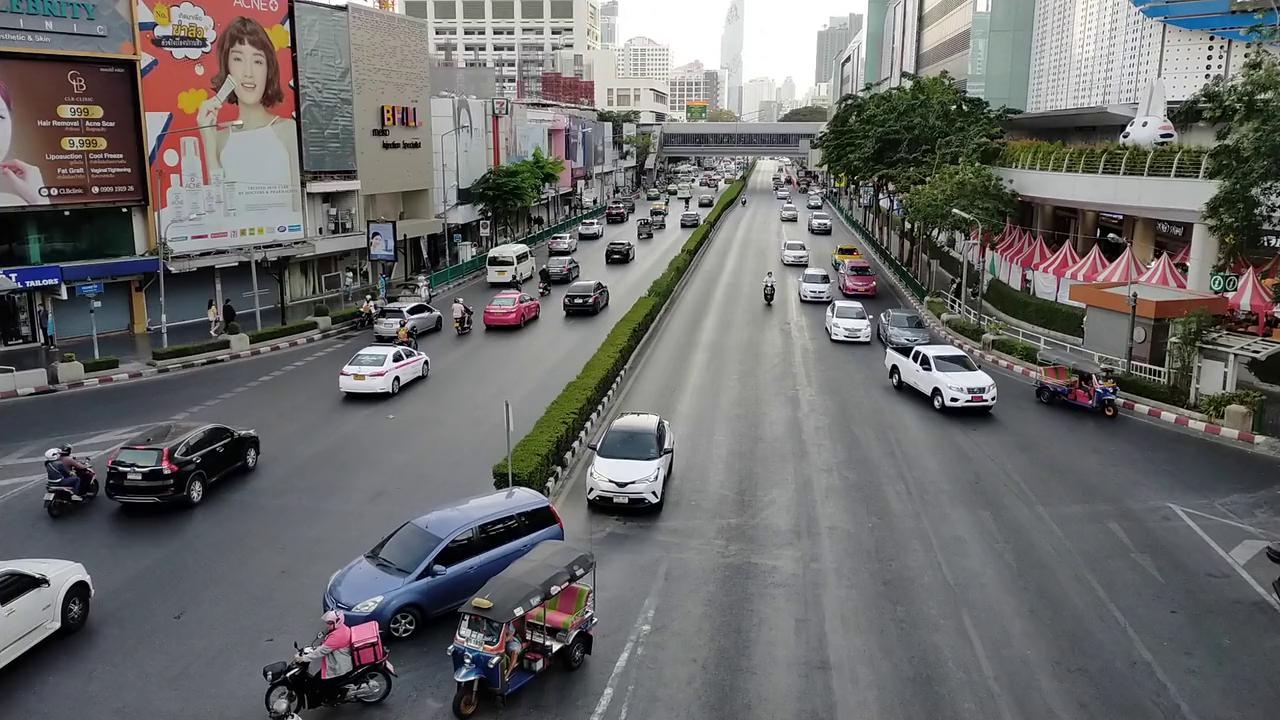
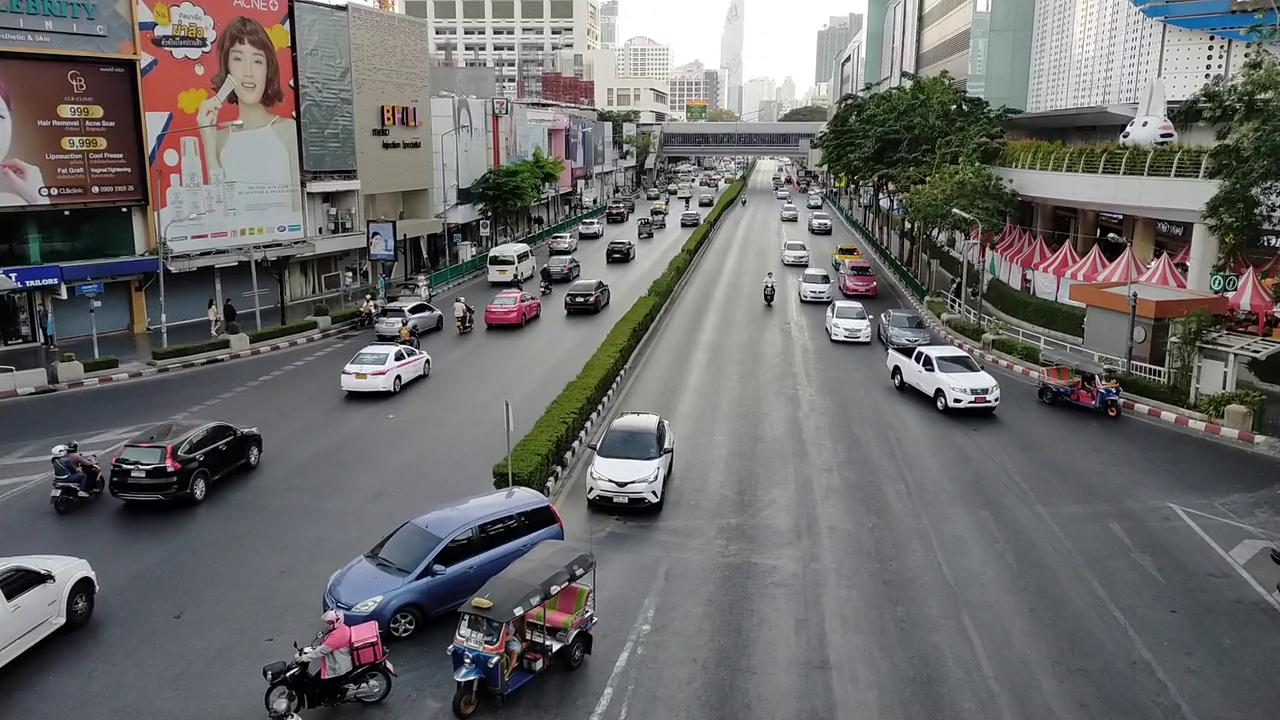
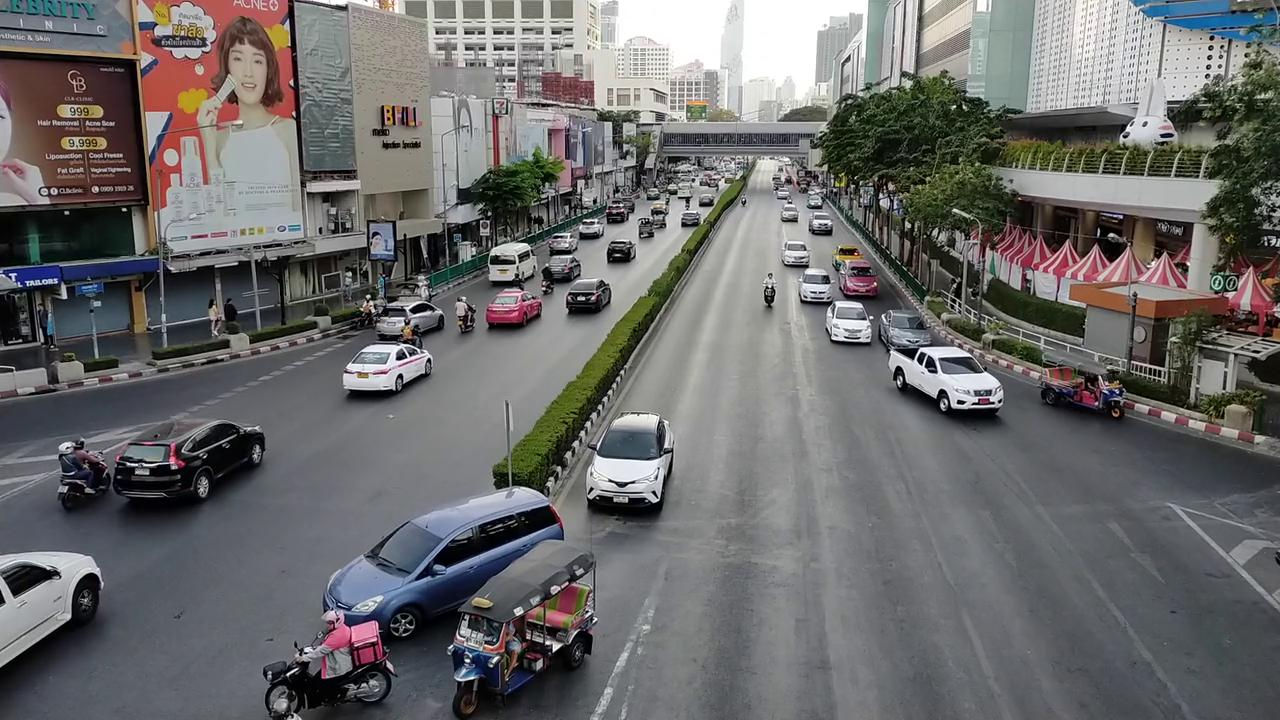
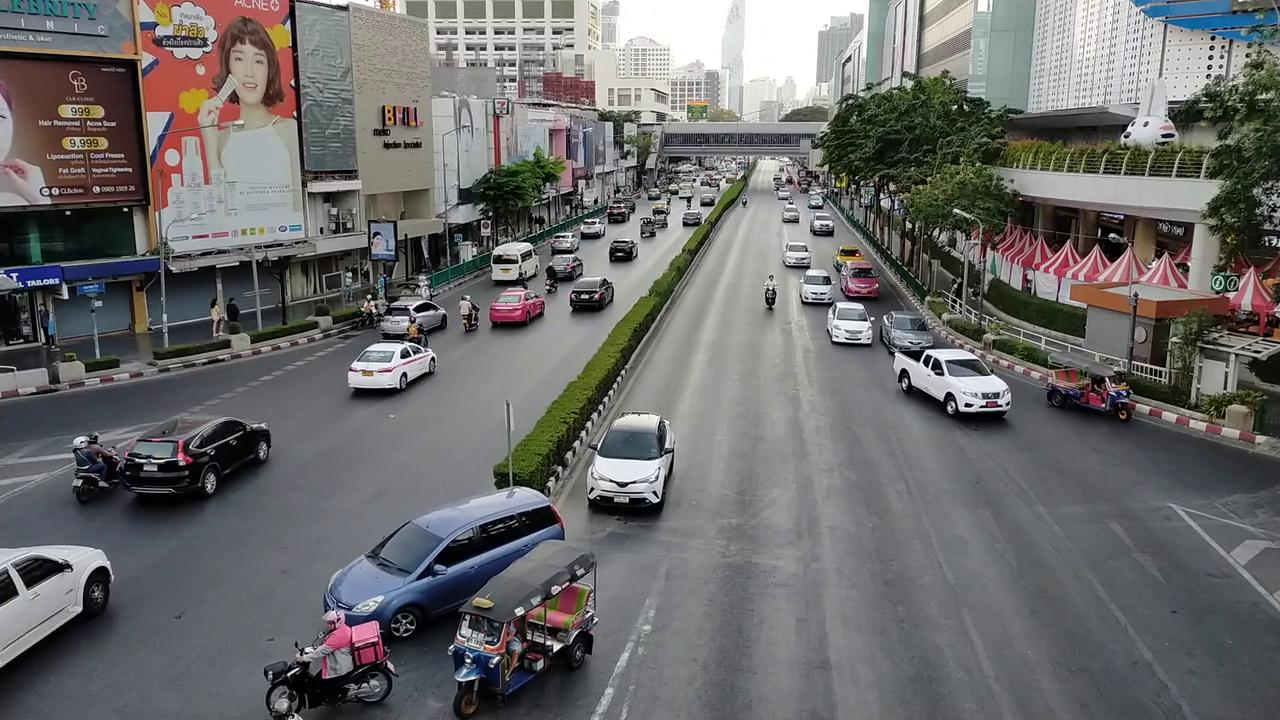
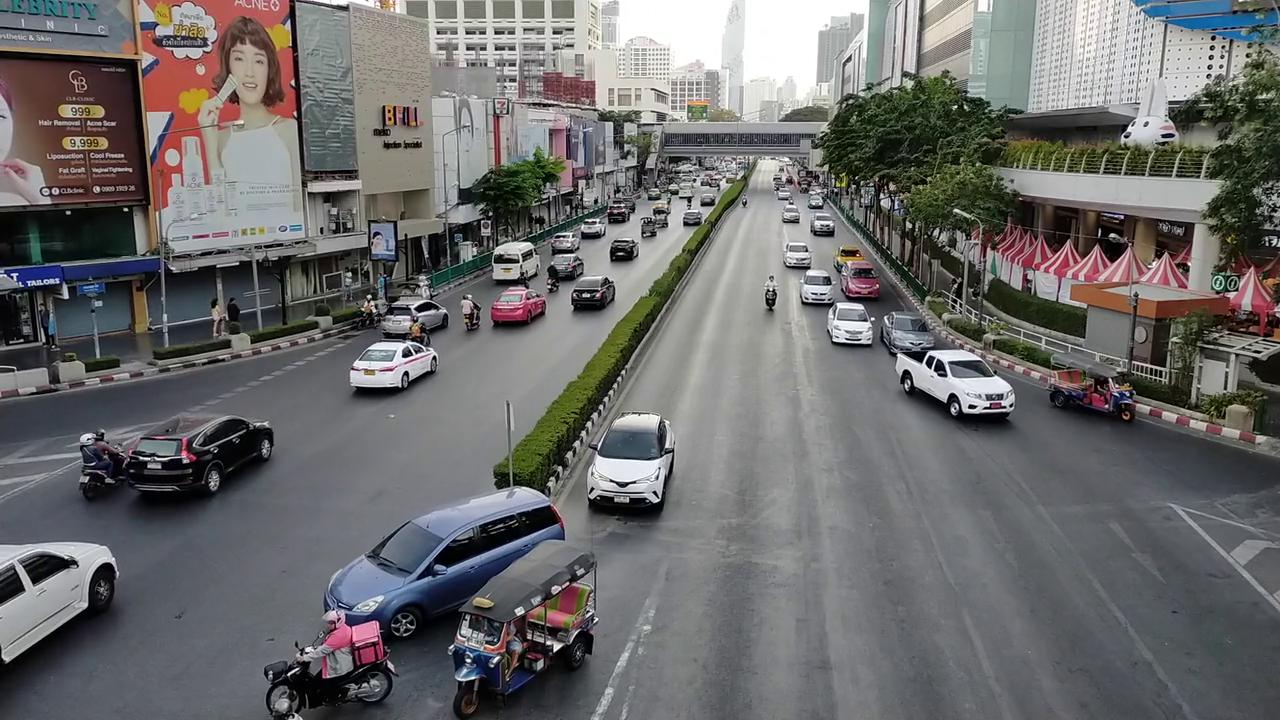

In [7]:
frames_view.select(frames_view.pos, frames_view.frame, frames_view.frame.width, frames_view.frame.height).show(5)

One advantage of using Pixeltable's component view mechanism is that Pixeltable does not physically store the frames. Instead, Pixeltable re-extracts the frames on retrieval using the frame index, which can be done very efficiently and avoids any storage overhead (which can be quite substantial for video frames).

## Object Detection with Pixeltable

Now let's apply an object detection model to our frames. Pixeltable includes built-in support for a number of models; we're going to use the YOLOX models, which are lightweight models with solid performance.

Recall that Pixeltable uses _computed columns_ for data manipulation (we encountered them in the Pixeltable Basics tutorial). Adding object detection as an incremental step in our workflow is as simple as adding a computed column to the `frames` view.

In [8]:
from pixeltable.functions.yolox import yolox

# Create a computed column to compute detections using the `yolox_s` (small) model.
frames_view['yolox_s'] = yolox(frames_view.frame, model_id='yolox_s', threshold=0.25)

Added column `yolox_s` to table `frames`.
Computing cells: 100%|████████████████████████████████████████| 462/462 [01:47<00:00,  4.30 cells/s]
Added 462 column values with 0 errors.


The new column is now part of the schema of `frames_view`:

In [9]:
frames_view = cl.get_table('video_tutorial.frames')

We can see that the object detection algorithm produced quite a lot of data for each frame.

frame,yolox_s
,"{'boxes': [[337.60125732421875, 342.8484802246094, 432.42486572265625, 399.2651672363281], [320.107666015625, 485.4398193359375, 567.1768188476562, 641.0172119140625], [102.09882354736328, 417.6628112792969, 264.8977355957031, 510.2859802246094], [0.5870208740234375, 557.0883178710938, 95.60978698730469, 668.7125854492188], [261.90728759765625, 631.4794921875, 394.915771484375, 720.5008544921875], [481.36773681640625, 289.3797302246094, 540.8989868164062, 330.5909118652344], [561.2442626953125, 279.8278503417969, 609.7703857421875, 318.9997863769531], [582.6569213867188, 412.0369567871094, 675.9461059570312, 513.15283203125], [824.3448486328125, 300.2709655761719, 875.6995849609375, 344.6018371582031], [602.9171752929688, 234.6815185546875, 635.7638549804688, 264.4610900878906], [369.8656005859375, 296.98040771484375, 442.978515625, 343.031005859375], [797.3073120117188, 270.2927551269531, 835.8213500976562, 304.1835632324219], [40.413360595703125, 443.15411376953125, 97.57757568359375, 517.054931640625], [312.0926818847656, 607.7630004882812, 351.1852111816406, 696.6231079101562], [881.55908203125, 344.3533020019531, 997.701171875, 412.8738098144531], [781.3193359375, 239.17091369628906, 809.7578125, 267.67279052734375], [839.5604248046875, 266.1596374511719, 877.9908447265625, 298.5497131347656], [543.5145874023438, 256.02447509765625, 580.5579223632812, 285.239990234375], [444.16009521484375, 543.1151733398438, 598.6427612304688, 691.7996215820312], [808.767578125, 213.17678833007812, 834.6009521484375, 235.23080444335938], [884.0758056640625, 338.1015625, 997.8201904296875, 414.1942138671875], [638.1619262695312, 208.7517852783203, 663.6172485351562, 239.0541534423828], [604.7455444335938, 203.15321350097656, 628.6013793945312, 225.4626922607422], [547.0503540039062, 231.9366455078125, 577.6284790039062, 253.94442749023438], [835.9971923828125, 255.59597778320312, 878.64404296875, 296.8030700683594], [643.804931640625, 203.7722930908203, 667.6790771484375, 229.6101837158203], [484.56201171875, 240.81051635742188, 539.4871826171875, 291.0112609863281], [574.42236328125, 217.7118377685547, 603.418212890625, 240.48692321777344], [449.6962890625, 611.3662719726562, 514.1318969726562, 718.3629760742188], [447.9178161621094, 541.7251586914062, 597.1364135742188, 706.7669067382812], [483.17218017578125, 240.69940185546875, 541.5653686523438, 294.3201904296875], [878.47900390625, 306.2352600097656, 951.052978515625, 351.3786926269531]], 'labels': [2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 3, 0, 2, 2, 2, 2, 2, 2, 7, 2, 2, 2, 2, 2, 2, 2, 3, 3, 7, 2], 'scores': [0.893894798473859, 0.8695018222946373, 0.8664620265420098, 0.8578381504367485, 0.8459837582107284, 0.8119247160165202, 0.7967813641651063, 0.7832498787650799, 0.7564551001452458, 0.721280421305643, 0.7140331576206194, 0.676137083391886, 0.6700914767139032, 0.669390190283238, 0.6632182110778899, 0.6506398850852833, 0.5508900830552221, 0.5380563122753905, 0.5346359033354524, 0.525728142573012, 0.48664094411034853, 0.4602785362057702, 0.4483374771002424, 0.4474962418190316, 0.4415847992198607, 0.40200579220560684, 0.38292878154202015, 0.3765064206830644, 0.37310918581147945, 0.33283685880538805, 0.3229361238294448, 0.265136414655224]}"

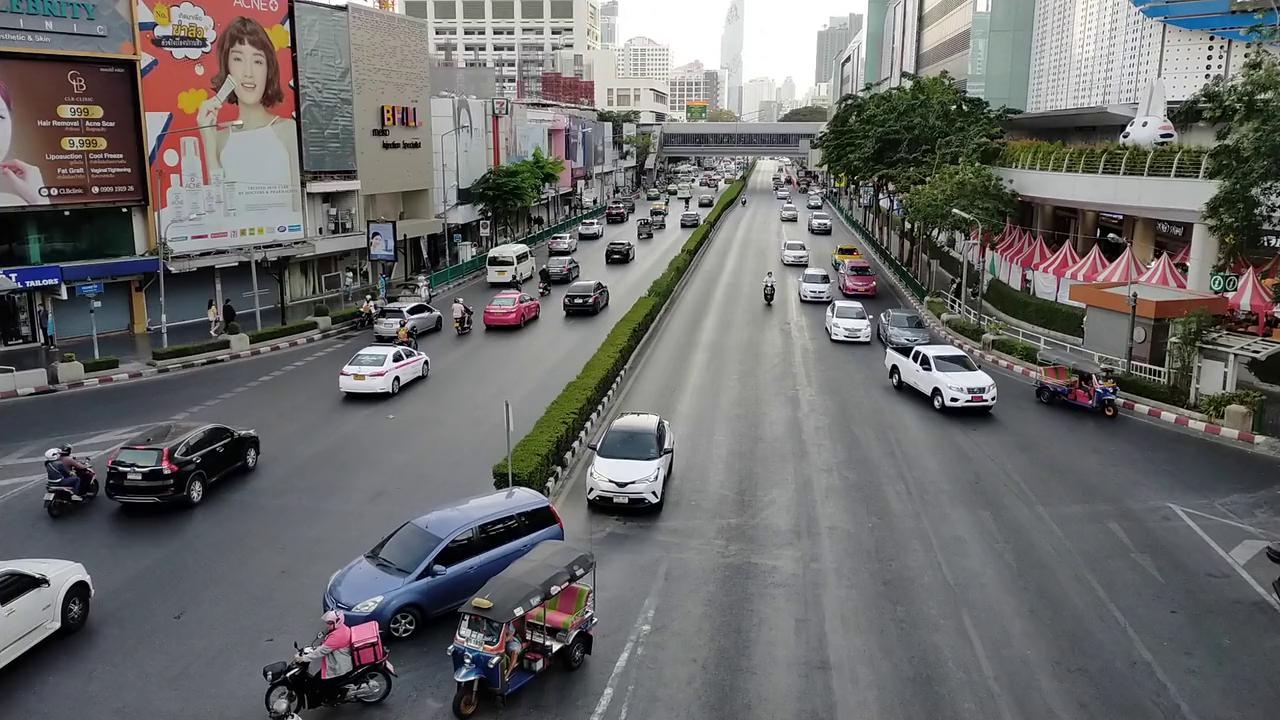

In [10]:
frames_view.select(frames_view.frame, frames_view.yolox_s).show(1)

Now let's create a new set of images, to illustrate the detected bounding boxes superimposed on the original images. There's no built-in Pixeltable function to do this, but we can easily create our own. We'll use the `@pxt.udf` decorator for this, as we first saw in the Pixeltable Basics tutorial.

In [11]:
import PIL.Image
import PIL.ImageDraw

@pxt.udf
def draw_boxes(img: PIL.Image.Image, boxes: list[list[float]]) -> PIL.Image.Image:
    result = img.copy()
    d = PIL.ImageDraw.Draw(result)
    for box in boxes:
        d.rectangle(box, width=3)
    return result

This function takes two arguments, `img` and `boxes`, and returns the new, annotated image. We could create a new computed column to hold the annotated images, but we don't have to; sometimes it's easier, especially when experimenting, just to use Pixeltable's powerful `select` comprehension:

frame,col_1
,

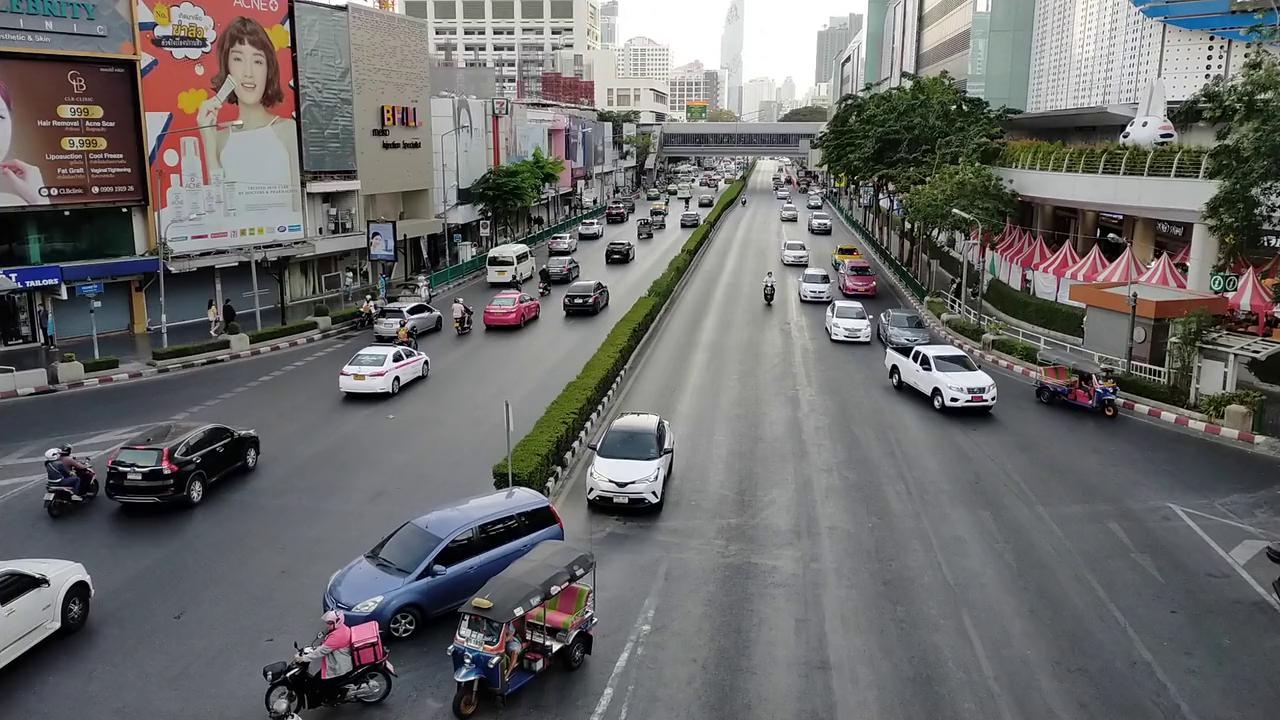
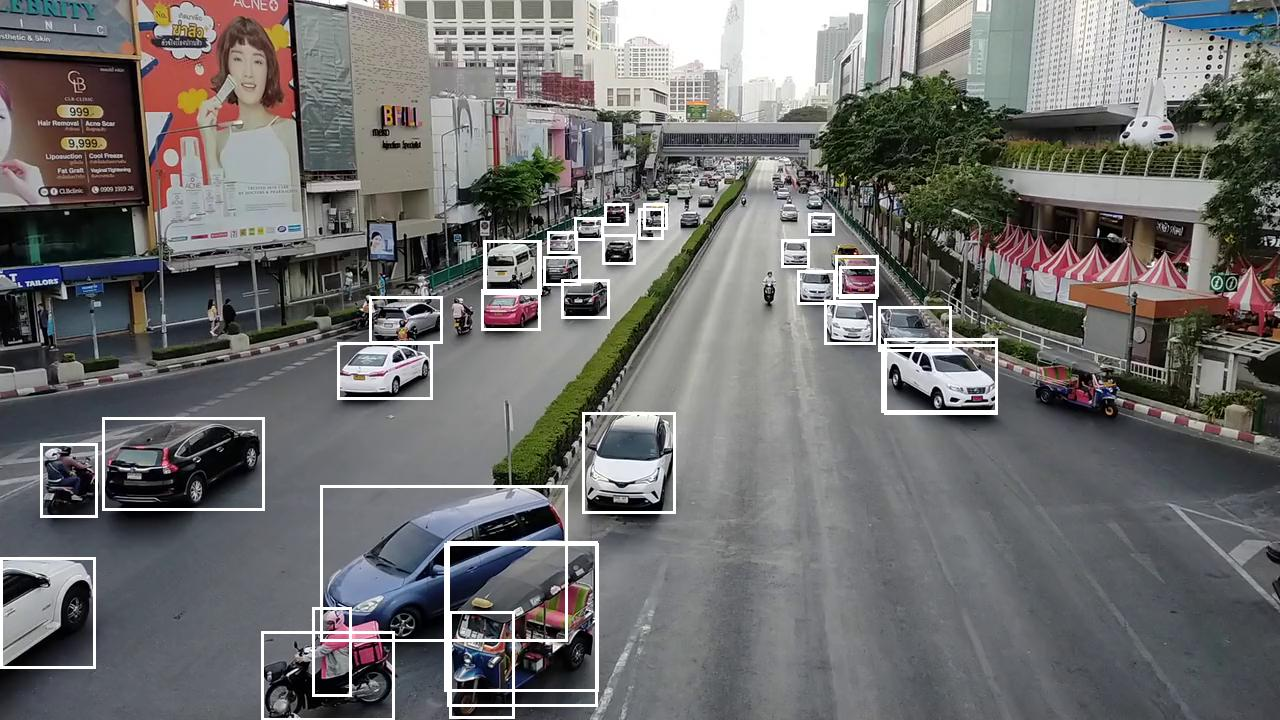

In [12]:
frames_view.select(frames_view.frame, draw_boxes(frames_view.frame, frames_view.yolox_s.boxes)).show(1)

Our `select` comprehension ranged over the entire table, so it might seem like we just created annotated images for 462 frames, but remember: image operations are performed at retrieval time, so in this case, Pixeltable drew the annotations just for the one frame that we actually displayed.

Looking at individual frames gives us some idea of how well our detection algorithm works, but it would be more instructive to turn the visualization output back into a video.

We do that with the built-in function `make_video()`, which is an aggregation function that takes a frame index (actually: any expression that can be used to order the frames; a timestamp would also work) and an image, and then assembles the sequence of images into a video.

In [13]:
frames_view.select(pxt.functions.make_video(
    frames_view.pos, draw_boxes(frames_view.frame, frames_view.yolox_s.boxes)
)).group_by(videos_table).show(1)

col_0
""


127.0.0.1 - - [19/Apr/2024 07:47:45] "GET //Users/asiegel/.pixeltable/tmp/tmps4n33jjl.mp4 HTTP/1.1" 200 -


## Comparing Object Detection Models

Now suppose we want to experiment with a more powerful object detection model, to see if there is any improvement in detection quality. We can create an additional column to hold the new inferences. The larger model takes longer to download and run, so please be patient.

In [14]:
# Here we use the larger `yolox_m` (medium) model.
frames_view['yolox_m'] = yolox(frames_view.frame, model_id='yolox_m', threshold=0.25)

Added column `yolox_m` to table `frames`.
Computing cells: 100%|████████████████████████████████████████| 462/462 [03:39<00:00,  2.11 cells/s]
Added 462 column values with 0 errors.


Let's see the results of the two models side-by-side.

In [16]:
frames_view.select(pxt.functions.make_video(
    frames_view.pos, draw_boxes(frames_view.frame, frames_view.yolox_s.boxes)
), pxt.functions.make_video(
    frames_view.pos, draw_boxes(frames_view.frame, frames_view.yolox_m.boxes)
)).group_by(videos_table).show(1)

col_0,col_1
,


127.0.0.1 - - [19/Apr/2024 08:04:18] "GET //Users/asiegel/.pixeltable/tmp/tmp6n8pry8i.mp4 HTTP/1.1" 200 -
127.0.0.1 - - [19/Apr/2024 08:04:18] "GET //Users/asiegel/.pixeltable/tmp/tmpdt9sthrt.mp4 HTTP/1.1" 200 -


Running the videos side-by-side, we can see that the larger model is (slightly) higher in quality: less flickering, with more stable boxes from frame to frame.

## Evaluating Models Against a Ground Truth

In order to do a quantitative evaluation of model performance, we need a ground truth to compare them against. Let's generate some (synthetic) "ground truth" data by running against the largest YOLOX model available.